Take Home Assignment 3

3.0 Install any dependencies if needed 


In [2]:
!pip install supervision
!pip install ultralytics

In [1]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [40]:
img = cv2.imread("demo5_images/cars1.jpg")


0: 416x640 14 cars, 258.6ms
Speed: 6.5ms preprocess, 258.6ms inference, 45.6ms postprocess per image at shape (1, 3, 416, 640)


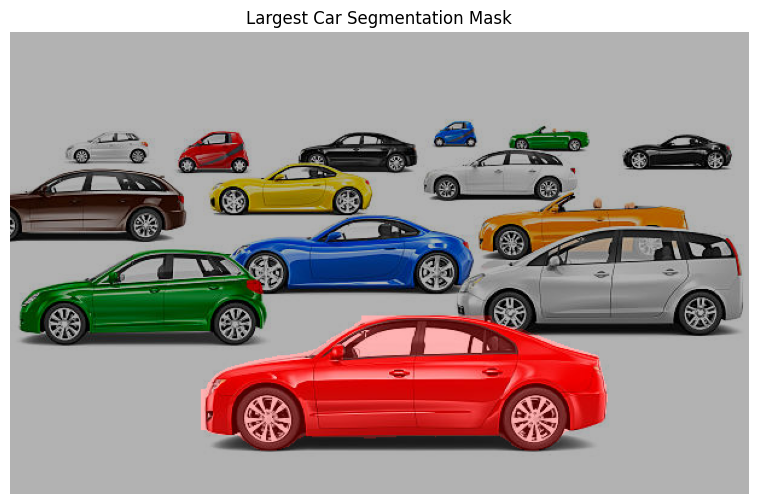

In [41]:
# Load YOLOv8 segmentation model
model = YOLO("yolov8n-seg.pt")  # Ensure you have YOLOv8 segmentation model

# Read the image
img = cv2.imread("demo5_images/cars1.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Run segmentation model
results = model(img_rgb)

# Extract masks and bounding boxes
largest_area = 0
largest_mask = None

for r in results:
    for mask, box, cls in zip(r.masks.xy, r.boxes.xyxy, r.boxes.cls):
        if int(cls) == 2:  # '2' corresponds to 'car' in COCO dataset
            mask = np.array(mask, dtype=np.int32)
            area = cv2.contourArea(mask)
            if area > largest_area:
                largest_area = area
                largest_mask = mask

# Draw the mask of the largest car
if largest_mask is not None:
    mask_img = np.zeros_like(img_rgb)
    cv2.fillPoly(mask_img, [largest_mask], (255, 0, 0))  # Fill with blue color

    # Overlay the mask on the original image
    overlaid_img = cv2.addWeighted(img_rgb, 0.7, mask_img, 0.3, 0)

    # Display result
    plt.figure(figsize=(10, 6))
    plt.imshow(overlaid_img)
    plt.axis("off")
    plt.title("Largest Car Segmentation Mask")
    plt.show()
else:
    print("No car detected in the image.")


3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 220.0ms
Speed: 6.0ms preprocess, 220.0ms inference, 33.6ms postprocess per image at shape (1, 3, 416, 640)


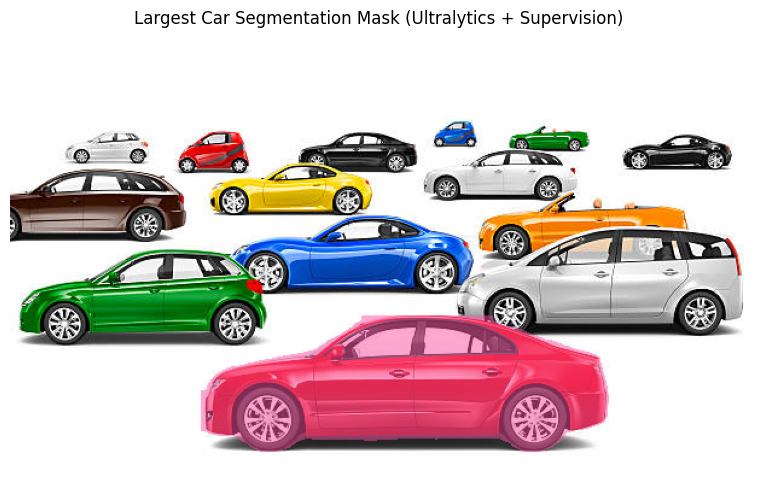

In [42]:
# Load YOLOv8 segmentation model
model = YOLO("yolov8n-seg.pt")  # Ensure you have YOLOv8 segmentation model

# Read the image
img = cv2.imread("demo5_images/cars1.jpg")

# Check if the image is loaded properly
if img is None:
    raise FileNotFoundError("Image file not found. Check the file path!")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying

# Run segmentation model
results = model(img_rgb)

# Create Supervision annotator for masks
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Extract the largest car mask
largest_area = 0
largest_mask = None
largest_bbox = None  # To store bounding box of largest car

for r in results:
    detections = sv.Detections.from_ultralytics(r)
    
    for mask, bbox, class_id in zip(detections.mask, detections.xyxy, detections.class_id):
        if class_id == 2:  # '2' corresponds to 'car' in COCO dataset
            area = np.count_nonzero(mask)  # Count nonzero pixels
            if area > largest_area:
                largest_area = area
                largest_mask = mask
                largest_bbox = bbox  # Store corresponding bounding box

# Draw the mask of the largest car
if largest_mask is not None:
    detections = sv.Detections(xyxy=np.array([largest_bbox]), mask=np.array([largest_mask]))

    mask_img = mask_annotator.annotate(scene=img_rgb, detections=detections)

    # Display result
    plt.figure(figsize=(10, 6))
    plt.imshow(mask_img)
    plt.axis("off")
    plt.title("Largest Car Segmentation Mask (Ultralytics + Supervision)")
    plt.show()
else:
    print("No car detected in the image.")


3.2 Estimate distance to centroid of chair 

Device set to use cpu



0: 384x640 1 chair, 140.6ms
Speed: 2.5ms preprocess, 140.6ms inference, 9.6ms postprocess per image at shape (1, 3, 384, 640)
Chair centroid: (352, 181), Estimated distance: 146


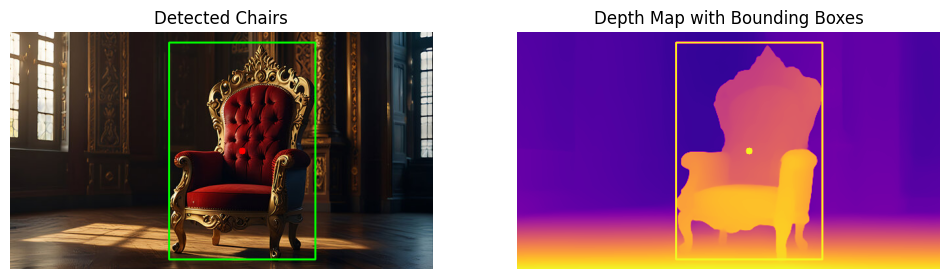

In [43]:
import cv2
import torch
import numpy as np
import supervision as sv
from ultralytics import YOLO
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt

# Load YOLO model for chair detection
detection_model = YOLO("yolov8n.pt")  # Use a suitable YOLO model

# Load Depth Anything V2 Small with GPU acceleration and FP16 precision if available
device = "cuda" if torch.cuda.is_available() else "cpu"
depth_estimator = pipeline(
    task="depth-estimation",
    model="depth-anything/Depth-Anything-V2-Small-hf",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

def detect_chair(image):
    results = detection_model(image)[0]
    chairs = []
    for box in results.boxes:
        class_id = int(box.cls.item())
        if results.names[class_id] == "chair":
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            centroid = ((x1 + x2) // 2, (y1 + y2) // 2)
            chairs.append((x1, y1, x2, y2, centroid))
    return chairs

def estimate_depth(image_path):
    image = Image.open(image_path)
    depth_map = depth_estimator(image)["depth"]
    depth_map_np = np.array(depth_map)  # Convert to NumPy array
    return depth_map_np

def main(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
    chairs = detect_chair(image)
    depth_map_np = estimate_depth(image_path)
    depth_map_rgb = np.stack([depth_map_np] * 3, axis=-1)  # Convert to 3-channel for visualization
    
    if chairs:
        for chair in chairs:
            x1, y1, x2, y2, centroid = chair
            depth = depth_map_np[centroid[1], centroid[0]]
            print(f"Chair centroid: {centroid}, Estimated distance: {depth}")
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.circle(image, centroid, 5, (255, 0, 0), -1)
            cv2.rectangle(depth_map_np, (x1, y1), (x2, y2), (255, 0, 255), 2)
            cv2.circle(depth_map_np, centroid, 5, (255, 0, 0), -1)
    else:
        print("No chair detected.")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title("Detected Chairs")
    axes[0].axis("off")
    
    axes[1].imshow(depth_map_np, cmap='plasma')
    axes[1].set_title("Depth Map with Bounding Boxes")
    axes[1].axis("off")
    
    plt.show()

# Example usage
main("demo5_images/kingChair.jpg")


3.3.1  Draw bounding boxes around the "cars" using supervision. 

In [6]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: e:\University\University lectures\4. Final Year\Semester 8\3. Machine Vision Systems\Assignments\THA 03\ETM4272-main\vehicles_video.mp4
100%|██████████| 35.3M/35.3M [00:20<00:00, 1.71MB/s]


'vehicles_video.mp4'

In [3]:
model = YOLO("yolo11n.pt")


def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Complete this function

    sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking.mp4",
    callback=callback
)

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [30]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

# Load the YOLO model
model = YOLO("yolo11n.pt")
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Print the class names to identify valid class IDs
print(f"Class Names: {model.names}")

# Vehicle class IDs based on the model's class names
# Adjust these IDs based on the printed class names
vehicle_class_ids = [2, 7]  # Adjusted to valid class IDs

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Run YOLO model on the frame
    results = model(frame)[0]
    
    # Debugging: Print class names
    print(f"Class Names: {results.names}")
    
    detections = sv.Detections.from_ultralytics(results)
    
    # Filter detections to only include vehicles using NumPy
    vehicle_detections = detections[np.isin(detections.class_id, vehicle_class_ids)]
    
    # Debugging: Check how many detections are left after filtering
    print(f"Number of vehicle detections: {len(vehicle_detections)}")

    # Track the filtered detections
    tracked_detections = tracker.update_with_detections(vehicle_detections)

    labels = [
        f"#{tracker_id} {results.names[class_id]}"
        for class_id, tracker_id
        in zip(tracked_detections.class_id, tracked_detections.tracker_id)
    ]

    # Annotate the frame with bounding boxes and labels
    annotated_frame = box_annotator.annotate(
        frame.copy(), detections=tracked_detections)
    return label_annotator.annotate(
        annotated_frame, detections=tracked_detections, labels=labels)

# Process video with the callback function
sv.process_video(
    source_path="vehicles_video.mp4",  # Ensure the correct path here
    target_path="result_track_vehicles.mp4",
    callback=callback
)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Class Names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone'

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [31]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
import cv2

# Load the YOLO model
model = YOLO("yolo11n.pt")
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Vehicle class IDs based on COCO dataset (adjust as needed)
vehicle_class_ids = [2, 7]

# Dictionary to store the path of each vehicle (tracker_id -> list of positions)
vehicle_paths = {}

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Run YOLO model on the frame
    results = model(frame)[0]
    
    # Debugging: Print class names
    # print(f"Class Names: {results.names}")
    
    detections = sv.Detections.from_ultralytics(results)
    
    # Filter detections to only include vehicles using NumPy
    vehicle_detections = detections[np.isin(detections.class_id, vehicle_class_ids)]
    
    # Debugging: Check how many detections are left after filtering
    # print(f"Number of vehicle detections: {len(vehicle_detections)}")

    # Track the filtered detections
    tracked_detections = tracker.update_with_detections(vehicle_detections)

    # Loop through the tracked detections to annotate and track paths
    labels = []
    for i, (tracker_id, class_id) in enumerate(zip(tracked_detections.tracker_id, tracked_detections.class_id)):
        label = f"#{tracker_id} {results.names[class_id]}"
        labels.append(label)

        # Get the center of the bounding box (x, y) using xyxy attribute
        x1, y1, x2, y2 = tracked_detections.xyxy[i]
        x_center = int((x1 + x2) / 2)
        y_center = int((y1 + y2) / 2)

        # Initialize the path for a new vehicle
        if tracker_id not in vehicle_paths:
            vehicle_paths[tracker_id] = []

        # Add the new center to the path of this vehicle
        vehicle_paths[tracker_id].append((x_center, y_center))

        # Draw the path (connect previous positions with a line)
        path = vehicle_paths[tracker_id]
        if len(path) > 1:
            for i in range(1, len(path)):
                cv2.line(frame, path[i-1], path[i], (0, 255, 0), 2)  # Green line

    # Annotate the frame with bounding boxes and labels
    annotated_frame = box_annotator.annotate(frame.copy(), detections=tracked_detections)
    
    # Annotate the frame with labels
    return label_annotator.annotate(annotated_frame, detections=tracked_detections, labels=labels)

# Process video with the callback function
sv.process_video(
    source_path="vehicles_video.mp4",  # Ensure the correct path here
    target_path="result_with_paths.mp4",
    callback=callback
)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 384x640 3 cars, 1 truck, 105.6ms
Speed: 4.4ms preprocess, 105.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 106.4ms
Speed: 4.0ms preprocess, 106.4ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 149.7ms
Speed: 3.0ms preprocess, 149.7ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 106.4ms
Speed: 5.8ms preprocess, 106.4ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 102.0ms
Speed: 3.4ms preprocess, 102.0ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 93.3ms
Speed: 4.0ms preprocess, 93.3ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 100.3ms
Speed: 4.0ms preprocess, 100.3ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 167.6ms
Speed: 3.0ms preproc

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does. 

Answers: Complete this section

The line `def callback(frame: np.ndarray, _: int) -> np.ndarray:` defines a callback function that processes individual frames in a video stream. Let's analyze its components:

Function Parameters:
1. `frame: np.ndarray`: 
   - The first parameter is a NumPy array representing a video frame
   - Contains the pixel data of the current frame being processed
   - Type annotation np.ndarray ensures type safety and code clarity

2. `_: int`:
   - The underscore represents an unused parameter
   - Convention in Python for parameters that are required but not utilized
   - In this context, likely represents the frame number or timestamp
   - Type annotation int specifies it accepts integer values

Return Type:
- `-> np.ndarray`: 
   - Arrow syntax indicates the function's return type
   - Returns a NumPy array containing the processed frame
   - Ensures type consistency in video processing pipeline

Purpose:
The callback function serves as a frame processor that:
- Receives raw video frames
- Applies object detection and tracking
- Adds visual annotations
- Returns the modified frame for video output

This function design pattern is common in video processing applications where each frame needs to be processed sequentially. The type annotations enhance code readability and maintainability while helping catch potential errors during development.